### Sensitivity limits for LZ (2022) and XENONnT (2022)

Here we show how to perform a grid scan of NSI parameters. For the sake of time, we show how to do a 1-binned analysis and with only on xenon isotope.  

In [1]:
import numpy as np

from snudd import config
from snudd.targets import Electron
from snudd.binding import binding_xe
from snudd.rrpa import rrpa_scaling
from snudd.targets import Nucleus


from snudd.models import GeneralNSI

from snudd.resolution import Resolution, Convolver # deals with the resolution effects on the rate


from snudd.efficiencies import efficiency_xnt_er_22 # efficiency curve from arxiv.org:2207.11330
from snudd.resolution import res_xnt_er

from snudd.efficiencies import efficiency_lz_nr, efficiency_lz_nr_22 # efficiency curve from arxiv:2207.03764
from snudd.resolution import res_lz_nr


In [2]:
phispace = np.linspace(-np.pi/2, np.pi/2,5) # phi domain
eps_space = np.linspace(3.0, -3.0, 5) # epsilon domain


In [3]:
phiGrid, epsGrid = np.meshgrid(phispace, eps_space, indexing='ij')


In [4]:
def counts_LZ22_NR(signal, E_Rs):
    exposure = 60*(1/365.25)*5.5 # in tn yr-1
    acceptance_cut = 0.9
    convolution_lz_sig = Convolver(E_Rs, signal , efficiency_lz_nr_22, res_lz_nr)
    return convolution_lz_sig.convolved_binned_rate(1.0e-7, 1.5e-5)*exposure*acceptance_cut

In [5]:
def counts_xnt_ER(signal, E_Rs):
    exposure = 1.16 # in tn yr-1
    acceptance_cut = 0.91  # 91% is quoted in 2207.11330
    convolution_xnt_sig= Convolver(E_Rs, signal , efficiency_xnt_er_22, res_xnt_er)
    
    return convolution_xnt_sig.convolved_binned_rate(1.0e-7, 3.0e-5)*exposure*acceptance_cut

In [6]:
from tqdm import tqdm

In [7]:
Xe_nucleus = Nucleus(54, 132, mass=131.9041535 * config.u) # only do one isotope for this example 
Xe_electron = Electron(Xe_nucleus, binding_xe, rrpa_scaling)


In [8]:
E_Rs = np.logspace(-2, 2, 1000) / 1e6  # Recoil energy in GeV, needed for the convolution to be broader than the bin considered


In [9]:
N_xnt22 = np.zeros(np.shape(phiGrid))
N_LZ = np.zeros(np.shape(phiGrid))

Below we calculate the ER and NR counts for each grid point. Because there are some large NSI parameters in the grid, SNuDD warns you the adiabatic apprximation may not be valid. 

In [10]:
for i in tqdm(range(len(phispace))):
    for j in range(len(eps_space)):
        
        NSI_matrix_tmp = np.array([[0, 1.0, 0],
                                   [1.0, 0.0, 0.0],
                                   [0, 0.0, 0.0]])*epsGrid[i,j]

        NSI_eta = 0.0
        NSI_phi_tmp = phiGrid[i,j]

        NSI_model_tmp = GeneralNSI(NSI_matrix_tmp, NSI_eta, NSI_phi_tmp)
        
        Xe_electron.update_model(NSI_model_tmp)
        Xe_nucleus.update_model(NSI_model_tmp)
        
        
        Xe_electron.prepare_density()
        Xe_nucleus.prepare_density()

        tmp_spec_NR = Xe_nucleus.spectrum(E_Rs)
        tmp_spec_ER = Xe_electron.spectrum(E_Rs)
        
        N_LZ[i,j] = counts_LZ22_NR(np.array(tmp_spec_NR).T, E_Rs )
        N_xnt22[i,j]= counts_xnt_ER(np.array(tmp_spec_ER).T, E_Rs)
        

  0%|                                                                                             | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_410/2561707893.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  N_LZ[i,j] = counts_LZ22_NR(np.array(tmp_spec_NR).T, E_Rs )
/tmp/ipykernel_410/2561707893.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  N_xnt22[i,j]= counts_xnt_ER(np.array(tmp_spec_ER).T, E_Rs)
100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.32s/it]


In [11]:
import matplotlib.pyplot as plt

Without performing any statistical analysis, we can plot contours for the number of recoils that are more than the expected amount from the SM 

According to [LZ](https://arxiv.org/pdf/2207.03764.pdf), the expected nuclear recoil was $0.14$, so we draw a line at $2.3$ which is allowed for the 90% C.L. fluctuation. 

According to [XENONnT](https://arxiv.org/pdf/2207.11330.pdf), they expected $300$ electronic recoils. We draw a line indicating $300 + \sqrt{300}$, understanding that this is *not* a replacement for proper statistical analysis which accounts for the backgrounds present as described in [our paper](https://arxiv.org/pdf/2302.12846.pdf).

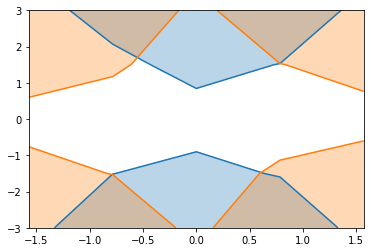

In [12]:
plt.contourf(phiGrid, epsGrid, N_LZ, levels=[2.3,np.infty], colors='tab:blue', alpha=0.3) 
plt.contour(phiGrid, epsGrid, N_LZ, levels=[2.3], colors='tab:blue') 
plt.contourf(phiGrid, epsGrid, N_xnt22, levels=[300.0+np.sqrt(300), np.infty], colors='tab:orange', alpha=0.3)
plt.contour(phiGrid, epsGrid, N_xnt22, levels=[ 300.0+np.sqrt(300)], colors='tab:orange')